# OWL2Vec

In [2]:
import sys
sys.path.append("../../../")

import torch as th
#import logging

from mowl.datasets.ppi_yeast import PPIYeastSlimDataset

from mowl.embeddings.graph_based.owl2vec.model import OWL2Vec
from gensim.models import Word2Vec
import pickle as pkl
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


#logging.basicConfig(level=logging.DEBUG)

## OWL2Vec

## OWL2Vec with Deepwalk

In [3]:
dataset = PPIYeastSlimDataset()
    
model = OWL2Vec(
    dataset, 
    "data/owl2vec_deepwalk", 
    bidirectional_taxonomy=True,
    include_literals = False,
    only_taxonomy = True,
    walking_method = "deepwalk",
    walk_length=50, 
    vector_size = 100,
    num_walks=32, 
    alpha=0,
    window=5,
    wv_epochs = 5,
    workers = 16
)

In [4]:
model.train()

INFO:root:Generating graph from ontology...
INFO:root:There are 1012351 triples in the ontology
INFO:root:Creating ontology graph projection...
INFO:root:	Extracting subsumption triples
INFO:root:		Time extracting subsumption: 34.760825872421265 seconds 
INFO:root:	Extracting equivalence triples
INFO:root:		Time extracting equivalences: 0.05426764488220215 seconds 
INFO:root:	Extracting class membership triples.
INFO:root:		Time extracting class membership: 83.96147155761719 seconds 
INFO:root:	Extracting sameAs triples
INFO:root:		Time extracting sameAs: 0.03590130805969238 seconds 
INFO:root:	Extracting triples associated to BFO_0000051
INFO:root:		Time extracting triples for property: 0.22390365600585938 seconds 
INFO:root:	Extracting triples associated to BFO_0000050
INFO:root:		Time extracting triples for property: 0.23398995399475098 seconds 
INFO:root:	Extracting triples associated to RO_0002093
INFO:root:		Time extracting triples for property: 0.313767671585083 seconds 
INFO:ro

Starting pool...+ started processing 7
+ started processing 4
+ started processing 5
+ started processing 6
+ started processing 2
+ started processing 0
+ started processing 1
+ started processing 3
+ started processing 9
+ started processing 8
+ started processing 10
+ started processing 11
+ started processing 12
+ started processing 14
+ started processing 13
+ started processing 15
- finished processing 4 after 36
- finished processing 11 after 35
- finished processing 10 after 36
- finished processing 0 after 41
- finished processing 2 after 41
- finished processing 5 after 41
- finished processing 6 after 41
- finished processing 8 after 41
- finished processing 3 after 42
- finished processing 13 after 37
- finished processing 9 after 43
- finished processing 1 after 43
- finished processing 12 after 39
- finished processing 7 after 44
- finished processing 14 after 40
- finished processing 15 after 39
* processing is over, shutting down the executor


INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 15 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 14 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 13 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 12 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 11 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 10 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 9 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 8 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 7 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 6 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 5 more threads
INFO:gensim.models.word2vec:worker thread finish

INFO:root:Word2Vec training finished
INFO:root:Saving model at data/owl2vec_deepwalk
INFO:gensim.utils:Word2Vec lifecycle event {'fname_or_handle': 'data/owl2vec_deepwalk', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2022-01-27T14:23:09.649984', 'gensim': '4.1.2', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) \n[GCC 9.4.0]', 'platform': 'Linux-5.4.0-94-generic-x86_64-with-glibc2.27', 'event': 'saving'}
INFO:gensim.utils:not storing attribute cum_table
INFO:gensim.utils:saved data/owl2vec_deepwalk
INFO:root:Model saved


In [6]:
word2VecModel = Word2Vec.load("data/owl2vec_deepwalk")

INFO:gensim.utils:loading Word2Vec object from data/owl2vec_deepwalk
INFO:gensim.utils:loading wv recursively from data/owl2vec_deepwalk.wv.* with mmap=None
INFO:gensim.utils:setting ignored attribute cum_table to None
INFO:gensim.utils:Word2Vec lifecycle event {'fname': 'data/owl2vec_deepwalk', 'datetime': '2022-01-27T14:23:33.547340', 'gensim': '4.1.2', 'python': '3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) \n[GCC 9.4.0]', 'platform': 'Linux-5.4.0-94-generic-x86_64-with-glibc2.27', 'event': 'loaded'}


In [7]:
vectors = word2VecModel.wv

In [8]:
dl2vec_deepwalk_embeddings = {}
for node in model.entities:
    if node.startswith("4932"):
        dl2vec_deepwalk_embeddings[node] = vectors[node]
        
with open("data/protDl2vecD_emb", "wb") as file:
    pkl.dump(dl2vec_deepwalk_embeddings, file)

In [9]:
ec_numbers = {}
with open('data/yeast_ec.tab') as f:
    next(f)
    for line in f:
        it = line.strip().split('\t', -1)
        if len(it) < 5:
            continue
        if it[3]:
            prot_id = it[3].split(';')[0]
            prot_id = '{0}'.format(prot_id)    
            ec_numbers[prot_id] = it[4]

In [10]:
ec_dict = {}
for prot in ec_numbers:
    if prot in dl2vec_deepwalk_embeddings:
        ec_dict[prot] = dl2vec_deepwalk_embeddings[prot]
        
size = model.vector_size
embeds = np.zeros((len(ec_dict), size), dtype=np.float32)

for i, emb in enumerate(ec_dict.values()):
    embeds[i, :] = emb
nodemap = {}
for i, m in enumerate(ec_dict.keys()):
    nodemap[i] = m
    

X = TSNE(n_components=2, verbose=1, n_iter=5000, n_jobs=8).fit_transform(embeds)

/home/zhapacfp/anaconda3/envs/mowl39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/zhapacfp/anaconda3/envs/mowl39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


ValueError: Found array with 0 sample(s) (shape=(0, 100)) while a minimum of 2 is required.

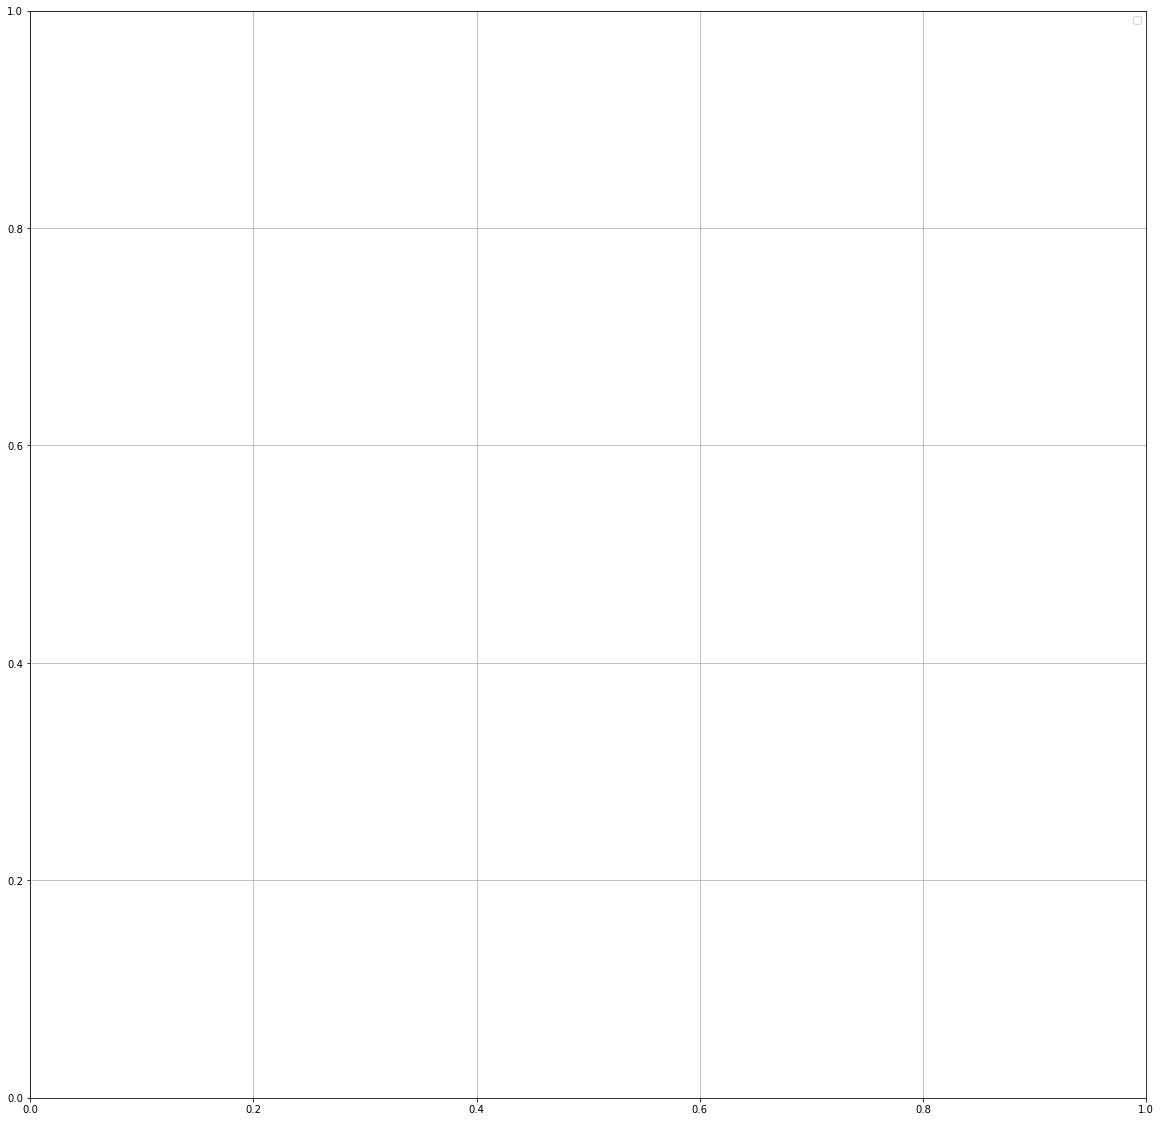

In [11]:
classes = {'0': [[], []]}
for item in nodemap.items():
    k, v = item
    if v in ec_numbers:
        ec = ec_numbers[v].split('.')[0]
        if ec not in classes:
            classes[ec] = [[], []]
        classes[ec][0].append(X[k, 0])
        classes[ec][1].append(X[k, 1])
        
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(classes))))
fig, ax = plt.subplots(figsize=(20, 20))

for ec, items in classes.items():
    if ec == '0':
        continue
    color = next(colors)
    ax.scatter(items[0], items[1], color=color, label=ec)

ax.legend()
ax.grid(True)
plt.savefig('data/fig_dl2vec_deepwalk.jpg')
plt.show()

## DL2Vec with Node2Vec

In [19]:
dataset = PPIYeastSlimDataset()
    
model = DL2Vec(
    dataset, 
    "data/dl2vec_node2vec", 
    bidirectional_taxonomy=True,
    walking_method = "node2vec",
    walk_length=50, 
    vector_size = 100,
    num_walks=32, 
    p = 10,
    q = 0.1,
    window=5,
    num_procs = 16
)

In [20]:
model.train()

INFO:root:Generating graph from ontology...


INFO: Number of ontology classes: 11020


INFO:root:Finished graph generation
INFO:root:Generating random walks...
INFO:root:Preprocessing transition probs...
INFO:root:Finished preprocessing
INFO:root:Walks generated
INFO:root:Starting to train the Word2Vec model
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 114475 words, keeping 10646 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #20000, processed 227679 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #30000, processed 338216 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #40000, processed 451597 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #50000, processed 566877 words, keeping 11020 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #60000, processed 679804 words, 

INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.word2vec:EPOCH - 1 : training on 3987341 raw words (2166682 effective words) took 4.6s, 467068 effective words/s
INFO:gensim.models.word2vec:EPOCH 2 - PROGRESS: at 13.47% examples, 283914 words/s, in_qsize 22, out_qsize 2
INFO:gensim.models.word2vec:EPOCH 2 - PROGRESS: at 35.95% examples, 384006 words/s, in_qsize 24, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 2 - PROGRESS: at 54.76% examples, 389205 words/s, in_qsize 30, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 2 - PROGRESS: at 75.36% examples, 402700 words/s, in_qsize 32, out_qsize 0
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 15 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 14 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 13 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 12 more thread

INFO:gensim.models.word2vec:EPOCH 6 - PROGRESS: at 55.03% examples, 392612 words/s, in_qsize 21, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 6 - PROGRESS: at 77.09% examples, 413666 words/s, in_qsize 28, out_qsize 0
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 15 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 14 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 13 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 12 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 11 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 10 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 9 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 8 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 7 more threads
IN

INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 13 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 12 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 11 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 10 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 9 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 8 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 7 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 6 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 5 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 4 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 3 more threads
INFO:gensim.models.word2vec:worker thread finished

INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 8 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 7 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 6 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 5 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 4 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 3 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.word2vec:EPOCH - 14 : training on 3987341 raw words (2166357 effective words) took 4.8s, 455905 effective words/s
INFO:gensim.models.word2vec:EPOCH 15 - PROGRESS: at 12.26% examples, 261777 words/s, in_qsize

INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 3 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.word2vec:EPOCH - 18 : training on 3987341 raw words (2167134 effective words) took 4.8s, 452255 effective words/s
INFO:gensim.models.word2vec:EPOCH 19 - PROGRESS: at 12.73% examples, 266067 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 19 - PROGRESS: at 34.69% examples, 368170 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 19 - PROGRESS: at 55.51% examples, 393322 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 19 - PROGRESS: at 78.12% examples, 417215 words/s, in_qsize 24, out_qsize 0
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 15 more thre

INFO:gensim.models.word2vec:EPOCH 23 - PROGRESS: at 12.51% examples, 269170 words/s, in_qsize 25, out_qsize 1
INFO:gensim.models.word2vec:EPOCH 23 - PROGRESS: at 34.69% examples, 368492 words/s, in_qsize 31, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 23 - PROGRESS: at 53.53% examples, 379833 words/s, in_qsize 32, out_qsize 0
INFO:gensim.models.word2vec:EPOCH 23 - PROGRESS: at 79.12% examples, 422477 words/s, in_qsize 18, out_qsize 0
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 15 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 14 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 13 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 12 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 11 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 10 more threads
INFO:gensim.models.word2vec:worker thr

INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 15 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 14 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 13 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 12 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 11 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 10 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 9 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 8 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 7 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 6 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 5 more threads
INFO:gensim.models.word2vec:worker thread finish

INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 10 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 9 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 8 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 7 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 6 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 5 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 4 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 3 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 2 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 1 more threads
INFO:gensim.models.word2vec:worker thread finished; awaiting finish of 0 more threads
INFO:gensim.models.word2vec:EPOCH - 31 : training on 

In [21]:
word2VecModel = Word2Vec.load("data/dl2vec_node2vec")
vectors = word2VecModel.wv

dl2vec_node2vec_embeddings = {}
for node in model.entities:
    if node.startswith("4932"):
        dl2vec_node2vec_embeddings[node] = vectors[node]
        
with open("data/protDl2vecN_emb", "wb") as file:
    pkl.dump(dl2vec_node2vec_embeddings, file)

INFO:gensim.utils:loading Word2Vec object from data/dl2vec_node2vec
INFO:gensim.utils:loading wv recursively from data/dl2vec_node2vec.wv.* with mmap=None
INFO:gensim.utils:setting ignored attribute cum_table to None
INFO:gensim.utils:Word2Vec lifecycle event {'fname': 'data/dl2vec_node2vec', 'datetime': '2022-01-10T00:58:14.448149', 'gensim': '4.1.2', 'python': '3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:46) \n[GCC 9.4.0]', 'platform': 'Linux-5.4.0-91-generic-x86_64-with-glibc2.27', 'event': 'loaded'}


In [22]:
ec_dict = {}
for prot in ec_numbers:
    if prot in dl2vec_node2vec_embeddings:
        ec_dict[prot] = dl2vec_node2vec_embeddings[prot]
        
size = model.vector_size
embeds = np.zeros((len(ec_dict), size), dtype=np.float32)

for i, emb in enumerate(ec_dict.values()):
    embeds[i, :] = emb
nodemap = {}
for i, m in enumerate(ec_dict.keys()):
    nodemap[i] = m
    

XN = TSNE(n_components=2, verbose=1, n_iter=5000, n_jobs=8).fit_transform(embeds)

Performing t-SNE using 8 cores.
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 171 of 1712
 - point 342 of 1712
 - point 513 of 1712
 - point 684 of 1712
 - point 855 of 1712
 - point 1026 of 1712
 - point 1197 of 1712
 - point 1368 of 1712
 - point 1539 of 1712
 - point 1710 of 1712
Done in 0.00 seconds (sparsity = 0.086159)!
Learning embedding...
Iteration 51: error is 74.854800 (50 iterations in 0.00 seconds)
Iteration 101: error is 74.840946 (50 iterations in 0.00 seconds)
Iteration 151: error is 74.841365 (50 iterations in 0.00 seconds)
Iteration 201: error is 74.840612 (50 iterations in 0.00 seconds)
Iteration 251: error is 74.840698 (50 iterations in 1.00 seconds)
Iteration 301: error is 2.054993 (50 iterations in 0.00 seconds)
Iteration 351: error is 1.672239 (50 iterations in 0.00 seconds)
Iteration 401: error is 1.554030 (50 iterations in 0.00 seconds)
Iteration 451: error is 1.498907 (50 iterations in

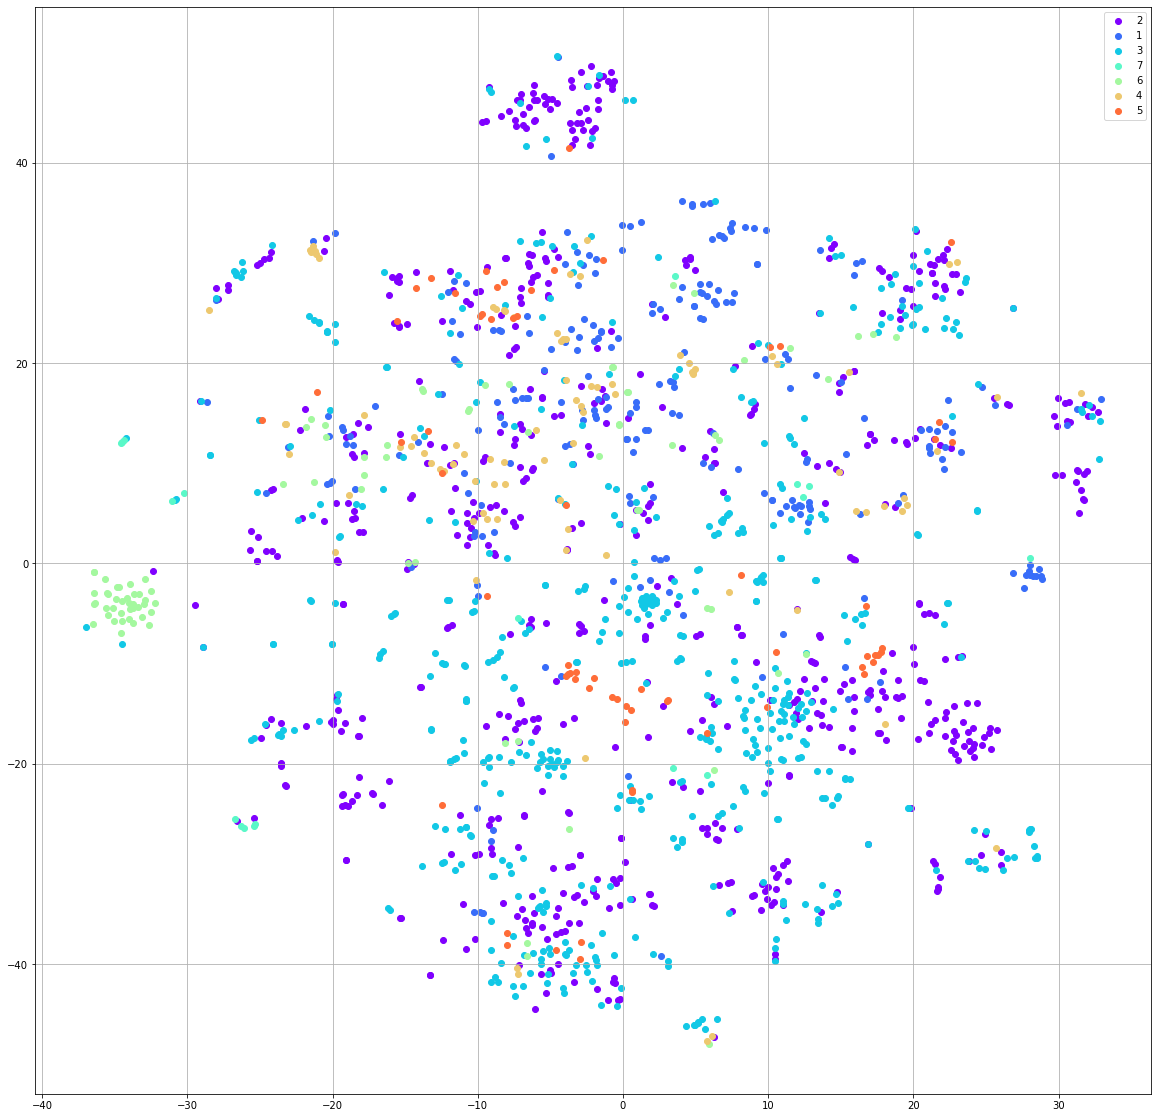

In [27]:
classes = {'0': [[], []]}
for item in nodemap.items():
    k, v = item
    if v in ec_numbers:
        ec = ec_numbers[v].split('.')[0]
        if ec not in classes:
            classes[ec] = [[], []]
        classes[ec][0].append(XN[k, 0])
        classes[ec][1].append(XN[k, 1])
        
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(classes))))
fig, ax = plt.subplots(figsize=(20, 20))

for ec, items in classes.items():
    if ec == '0':
        continue
    color = next(colors)
    ax.scatter(items[0], items[1], color=color, label=ec)

ax.legend()
ax.grid(True)
plt.savefig('data/fig_dl2vec_node2vec.jpg')

plt.show()